In [1]:
import pymc3 as pm
import pandas as pd
from scipy.stats import norm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

def bayesian_ab_test(num_users_control, num_events_control, num_users_variant, num_events_variant):
    # Prior parameters (Beta distribution)
    alpha_prior = 1  # Prior shape parameter
    beta_prior = 1   # Prior scale parameter

    # Calculate posterior parameters for control and variant groups
    alpha_control = alpha_prior + num_events_control
    beta_control = beta_prior + num_users_control - num_events_control

    alpha_variant = alpha_prior + num_events_variant
    beta_variant = beta_prior + num_users_variant - num_events_variant

    # Generate posterior distributions
    posterior_control = beta(alpha_control, beta_control)
    posterior_variant = beta(alpha_variant, beta_variant)

    # Calculate probabilities of variant being better
    p_variant_better = posterior_control.cdf(posterior_variant.mean())

    # Calculate conversion rates for control and variant groups
    conversion_rate_control = num_events_control / num_users_control
    conversion_rate_variant = num_events_variant / num_users_variant

    # Calculate uplift
    uplift = 100*((conversion_rate_variant-conversion_rate_control)/conversion_rate_control)

    # Define subjective interpretation bands
    result_bands = {
        (0, 0.1): 'strong negative',
        (0.1, 0.2): 'moderate negative',
        (0.2, 0.5): 'weak negative',
        (0.5, 0.8): 'weak positive',
        (0.8, 0.9): 'moderate positive',
        (0.9, 1): 'strong positive'
    }

    # Get the subjective interpretation
    interpretation = ''
    for band, label in result_bands.items():
        if band[0] <= p_variant_better < band[1]:
            interpretation = label
            break

    # Output as percentage
    p_variant_better_percentage = round(p_variant_better * 100, 2)

    # Plot KDEs for the posterior distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(posterior_control.rvs(10000), label='Control')
    sns.kdeplot(posterior_variant.rvs(10000), label='Variant')
    plt.title('Posterior Distribution KDEs')
    plt.xlabel('Conversion Rate')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return {
        'probability_to_be_better': p_variant_better_percentage,
        'conversion_rate_control': round(conversion_rate_control * 100, 2),
        'conversion_rate_variant': round(conversion_rate_variant * 100, 2),
        'uplift': round(uplift, 2),
        'interpretation': f"The probability that the Variant group is better than Control is {p_variant_better_percentage}%. "
                          f"Uplift: {uplift}%. Result interpretation: {interpretation}."
    }


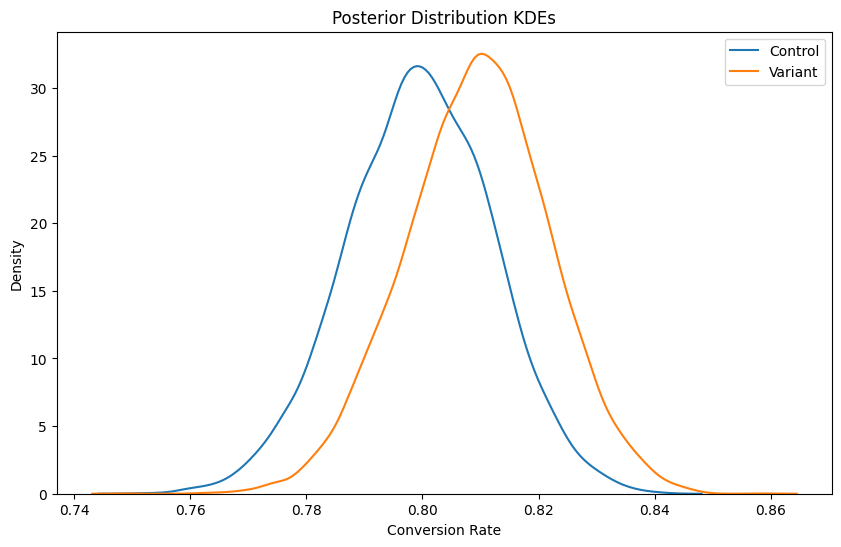

{'probability_to_be_better': 78.32,
 'conversion_rate_control': 80.0,
 'conversion_rate_variant': 81.0,
 'uplift': 1.25,
 'interpretation': 'The probability that the Variant group is better than Control is 78.32%. Uplift: 1.250000000000001%. Result interpretation: weak positive.'}

In [3]:
bayesian_ab_test(1000,800,1000,810)

In [9]:
# Simulate data
np.random.seed(42)

# Simulate data for Group A (control)
group_a_mean = 50
group_a_std = 15
group_a_size = 500
group_a = np.random.normal(group_a_mean, group_a_std, group_a_size)
df_a = pd.DataFrame({
    'user_id': range(1, group_a_size + 1),
    'group': 'control',
    'value': group_a
})

# Simulate data for Group B (variant)
group_b_mean = 50
group_b_std = 15
group_b_size = 500
group_b = np.random.normal(group_b_mean, group_b_std, group_b_size)
df_b = pd.DataFrame({
    'user_id': range(group_a_size + 1, group_a_size + group_b_size + 1),
    'group': 'variant',
    'value': group_b
})

# Concatenate both groups into a single DataFrame
df = pd.concat([df_a, df_b])
?
# Display a sample of the DataFrame
print(df.head())

   user_id    group      value
0        1  control  57.450712
1        2  control  47.926035
2        3  control  59.715328
3        4  control  72.845448
4        5  control  46.487699



IPython -- An enhanced Interactive Python

IPython offers a fully compatible replacement for the standard Python
interpreter, with convenient shell features, special commands, command
history mechanism and output results caching.

At your system command line, type 'ipython -h' to see the command line
options available. This document only describes interactive features.

GETTING HELP
------------

Within IPython you have various way to access help:

  ?         -> Introduction and overview of IPython's features (this screen).
  object?   -> Details about 'object'.
  object??  -> More detailed, verbose information about 'object'.
  %quickref -> Quick reference of all IPython specific syntax and magics.
  help      -> Access Python's own help system.

If you are in terminal IPython you can quit this screen by pressing `q`.


MAIN FEATURES
-------------

* Access to the standard Python help with object docstrings and the Python
  manuals. Simply type 'help' (no quotes) to invoke it.

* Ma

In [14]:
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sb

def run_bayesian_estimation(df):
    y1 = df[df['group'] == 'control']['value'].values
    y2 = df[df['group'] == 'variant']['value'].values

    with pm.Model() as model:
        μ_m = df['value'].mean()
        μ_s = df['value'].std() * 2

        group1_mean = pm.Normal("group1_mean", mu=μ_m, sigma=μ_s)
        group2_mean = pm.Normal("group2_mean", mu=μ_m, sigma=μ_s)

        σ_low = 1
        σ_high = 10
        group1_std = pm.Uniform("group1_std", lower=σ_low, upper=σ_high)
        group2_std = pm.Uniform("group2_std", lower=σ_low, upper=σ_high)

        ν = pm.Exponential("ν_minus_one", 1 / 29.0) + 1

        λ1 = group1_std ** -2
        λ2 = group2_std ** -2

        group1 = pm.StudentT("control", nu=ν, mu=group1_mean, lam=λ1, observed=y1)
        group2 = pm.StudentT("variant", nu=ν, mu=group2_mean, lam=λ2, observed=y2)

        trace = pm.sample(10000, return_inferencedata=True)
    
    az_summary = az.summary(trace, var_names=["group1_mean", "group2_mean"])
    modeled_mean_control = az_summary.loc['group1_mean', 'mean']
    modeled_mean_variant = az_summary.loc['group2_mean', 'mean']
    
    # Calculate the difference of means manually
    diff_means = trace.posterior["group2_mean"].values - trace.posterior["group1_mean"].values
    uplift = 100 * ((modeled_mean_variant - modeled_mean_control) / modeled_mean_control)
    
    prob_group_better = (diff_means > 0).mean()

    print(f"Modeled mean of Control: {modeled_mean_control:.4f}")
    print(f"Modeled mean of Variant: {modeled_mean_variant:.4f}")
    print(f"Relative uplift from Control to Variant: {uplift:.4f}")
    print(f"Probability Variant is better than Control: {prob_group_better:.4f}")

    # Displaying the trace as a table
    trace_df = pm.summary(trace).round(4)
    print(trace_df)

    plot = sb.kdeplot(y ='value', data=df, hue='group', fill=True, common_norm=False, palette="crest")

    return trace, plot


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 11 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparam

Modeled mean of Control: 49.8390
Modeled mean of Variant: 50.2850
Relative uplift from Control to Variant: 0.8949
Probability Variant is better than Control: 0.7047
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
group1_mean  49.839  0.589  48.751   50.971      0.003    0.002   32739.0   
group2_mean  50.285  0.596  49.178   51.410      0.003    0.002   35979.0   
group1_std    9.921  0.077   9.780   10.000      0.000    0.000   23118.0   
group2_std    9.920  0.078   9.779   10.000      0.000    0.000   20463.0   
ν_minus_one   2.691  0.364   2.038    3.383      0.002    0.002   23390.0   

             ess_tail  r_hat  
group1_mean   27499.0    1.0  
group2_mean   27556.0    1.0  
group1_std    16058.0    1.0  
group2_std    13638.0    1.0  
ν_minus_one   22702.0    1.0  


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 <Axes: xlabel='Density', ylabel='value'>)

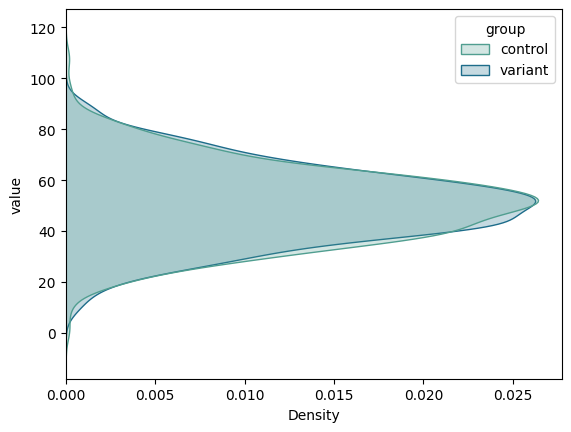

In [15]:
run_bayesian_estimation(df)

In [25]:
def calculate_bayesian_sample_size_and_days(min_detectable_effect, baseline_conversion, confidence_level=0.95, power=0.9, daily_traffic=1000, groups_in_test=1):
    # Define a PyMC3 model
    with pm.Model() as model:
        # Define prior distributions for conversion rates
        p_baseline = pm.Beta('p_baseline', alpha=1, beta=1)
        p_variant = pm.Beta('p_variant', alpha=1, beta=1)
        
        # Define likelihood for observed data
        obs_baseline = pm.Binomial('obs_baseline', n=1, p=p_baseline, observed=baseline_conversion)
        obs_variant = pm.Binomial('obs_variant', n=1, p=p_variant, observed=baseline_conversion + min_detectable_effect)
        
        # Calculate the required sample size for the specified MDE, confidence level, and power
        pm.Deterministic('sample_size', (2 * (p_baseline - p_variant) / min_detectable_effect) ** 2)
    
    # Perform MCMC sampling
    with model:
        trace = pm.sample(10000, tune=10000, cores=10)
    
    # Extract the sample size from the trace
    bayesian_sample_size = int(trace['sample_size'].mean())
    
    # Calculate the net sample size required for all groups
    net_sample_size = bayesian_sample_size * groups_in_test
    
    # Calculate the number of days needed
    days_needed = net_sample_size / daily_traffic
    
    return net_sample_size, days_needed

# Example usage:
min_detectable_effect = 0.01  # MDE of 10%
baseline_conversion = 0.033  # 3.3% baseline conversion rate
daily_traffic = 1000  # Daily traffic
groups_in_test = 2  # Number of groups in the test
net_sample_size, days_needed = calculate_bayesian_sample_size_and_days(min_detectable_effect, baseline_conversion, power=0.9, daily_traffic=daily_traffic, groups_in_test=groups_in_test)
print(f"Net Sample Size: {net_sample_size}")
print(f"Days Needed: {days_needed}")


/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [p_variant, p_baseline]


/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continu

Net Sample Size: 9050
Days Needed: 9.05


In [11]:
import pymc3 as pm
import numpy as np
from scipy.stats import norm

def calculate_bayesian_sample_size_continuous(min_detectable_effect, baseline_mean, baseline_stddev, confidence_level=0.95, power=0.9, daily_traffic=1000, groups_in_test=1):
    # Define a PyMC3 model
    with pm.Model() as model:
        # Define prior distributions for baseline and variant means
        mu_baseline = pm.Normal('mu_baseline', mu=baseline_mean, sd=baseline_stddev)
        mu_variant = pm.Normal('mu_variant', mu=baseline_mean + min_detectable_effect, sd=baseline_stddev)
        
        # Simulate data for baseline and variant
        data_baseline = pm.Normal('data_baseline', mu=mu_baseline, sd=baseline_stddev)
        data_variant = pm.Normal('data_variant', mu=mu_variant, sd=baseline_stddev)
        
        # Calculate the required sample size for the specified MDE, confidence level, and power
        ppf_alpha = norm.ppf(1 - (1 - confidence_level) / 2)
        ppf_power = norm.ppf(power)
        
        sample_size = (
            (ppf_alpha + ppf_power) ** 2 /
            (min_detectable_effect ** 2)
        )
    
    # Perform MCMC sampling
    with model:
        trace = pm.sample(10000, tune=10000, cores=10)
    
    # Extract the sample size from the trace
    bayesian_sample_size = int(sample_size)
    
    # Calculate the net sample size required for all groups
    net_sample_size = bayesian_sample_size * groups_in_test
    
    # Calculate the number of days needed
    days_needed = net_sample_size / daily_traffic
    
    return net_sample_size, days_needed

# Example usage:
min_detectable_effect = 0.01  # MDE of 10%
baseline_mean = 11  # Baseline mean
baseline_stddev = 22  # Baseline standard deviation
daily_traffic = 10000  # Daily traffic
groups_in_test = 3 # Number of groups in the test

net_sample_size, days_needed = calculate_bayesian_sample_size_continuous(
    min_detectable_effect, baseline_mean, baseline_stddev, power=0.9, daily_traffic=daily_traffic, groups_in_test=groups_in_test)

print(f"Net Sample Size: {net_sample_size}")
print(f"Days Needed: {days_needed}")


/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [data_variant, data_baseline, mu_variant, mu_baseline]


/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continu

Net Sample Size: 315222
Days Needed: 31.5222


In [3]:
import pandas as pd
import numpy as np

# Generate example data
np.random.seed(0)  # for reproducibility
n_samples = 1000  # number of samples
mean_control = 11.55  # mean of the control group
stddev_control = 20  # standard deviation of the control group

# Create a DataFrame
data = {
    'value': np.random.normal(mean_control, stddev_control, n_samples)
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())

       value
0  46.831047
1  19.553144
2  31.124760
3  56.367864
4  48.901160


In [4]:
len(df)

1000

In [8]:
import pymc3 as pm
import numpy as np
from scipy.stats import norm

def calculate_bayesian_sample_size_continuous(df, daily_traffic, groups_in_test, min_detectable_effect, confidence_level=0.95, power=0.9):
    # Extract the continuous metric data from the DataFrame
    baseline_data = df['value'].values
    
    # Calculate the baseline mean and standard deviation from the data
    baseline_mean = np.mean(baseline_data)
    baseline_stddev = np.std(baseline_data)
    
    # Define a PyMC3 model
    with pm.Model() as model:
        # Define prior distributions for baseline and variant means
        mu_baseline = pm.Normal('mu_baseline', mu=baseline_mean, sd=baseline_stddev)
        mu_variant = pm.Normal('mu_variant', mu=baseline_mean + min_detectable_effect, sd=baseline_stddev)
        
        # Simulate data for baseline and variant
        data_baseline = pm.Normal('data_baseline', mu=mu_baseline, sd=baseline_stddev, observed=baseline_data)
        data_variant = pm.Normal('data_variant', mu=mu_variant, sd=baseline_stddev)
        
        # Calculate the required sample size for the specified MDE, confidence level, and power
        ppf_alpha = norm.ppf(1 - (1 - confidence_level) / 2)
        ppf_power = norm.ppf(power)
        
        sample_size = (
            ((ppf_alpha + ppf_power) * baseline_stddev / min_detectable_effect) ** 2
        )
    
    # Perform MCMC sampling
    with model:
        trace = pm.sample(10000, tune=10000, cores=10)
    
    # Extract the sample size from the trace
    bayesian_sample_size = int(sample_size)
    
    # Calculate the net sample size required for all groups
    net_sample_size = bayesian_sample_size * groups_in_test
    
    # Calculate the number of days needed
    days_needed = net_sample_size / daily_traffic
    
    return net_sample_size, days_needed

# Input daily traffic, number of groups in the test, and minimum detectable effect (MDE)
daily_traffic = 250000  # Daily traffic
groups_in_test = 2  # Number of groups in the test
min_detectable_effect = 0.05  # MDE of 10%

net_sample_size, days_needed = calculate_bayesian_sample_size_continuous(
    df, daily_traffic, groups_in_test, min_detectable_effect, power=0.9)

print(f"Net Sample Size: {net_sample_size}")
print(f"Days Needed: {days_needed}")


/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [data_variant, mu_variant, mu_baseline]


/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/HopkiFW1/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continu

Net Sample Size: 3275740
Days Needed: 13.10296


In [5]:

data = {
    'group': ['Control', 'Variant', 'Variant 2', 'Variant 3', 'Variant 4', 'Variant 5'],
    'value': [100, 110, 112, 115, 108, 111]
}

df = pd.DataFrame(data)

# Mapping function to group labels
def map_group_label(label):
    control_labels = ['0', 'Control', 'default', 'Default']
    variant_labels = ['1', 'Variant', 'test', 'Test']

    if label in control_labels:
        return 'control'
    elif label in variant_labels:
        return 'variant'
    elif label.startswith('Variant'):
        return 'variant'
    else:
        return 'unknown'

df['group'] = df['group'].apply(map_group_label)

# Function for Bayesian estimation with continuous data
def run_continuous_bayesian_estimation(df):
    result_text = []
    result_table = []

    for variant_num in range(1, 6):  # Handle up to 5 variants
        variant_label = f'Variant {variant_num}'
        y1 = df[df['group'] == 'control']['value'].values
        y2 = df[df['group'] == variant_label]['value'].values

        with pm.Model() as model:
            μ_m = df['value'].mean()
            μ_s = df['value'].std() * 2

            group1_mean = pm.Normal("group1_mean", mu=μ_m, sigma=μ_s)
            group2_mean = pm.Normal("group2_mean", mu=μ_m, sigma=μ_s)

            σ_low = 1
            σ_high = 10
            group1_std = pm.Uniform("group1_std", lower=σ_low, upper=σ_high)
            group2_std = pm.Uniform("group2_std", lower=σ_low, upper=σ_high)

            ν = pm.Exponential("ν_minus_one", 1 / 29.0) + 1

            λ1 = group1_std ** -2
            λ2 = group2_std ** -2

            group1 = pm.StudentT("control", nu=ν, mu=group1_mean, lam=λ1, observed=y1)
            group2 = pm.StudentT("variant", nu=ν, mu=group2_mean, lam=λ2, observed=y2)

            trace = pm.sample(5000, return_inferencedata=True)

        az_summary = az.summary(trace, var_names=["group1_mean", "group2_mean"])
        modeled_mean_control = az_summary.loc['group1_mean', 'mean']
        modeled_mean_variant = az_summary.loc['group2_mean', 'mean']

        # Calculate the difference of means manually
        diff_means = trace.posterior["group2_mean"].values - trace.posterior["group1_mean"].values
        uplift = round((100 * ((modeled_mean_variant - modeled_mean_control) / modeled_mean_control)), 2)

        prob_group_better = round((diff_means > 0).mean(), 2)

        result_text.append(html.Table(
            [html.Tr([html.Td(f"Modeled mean of Control: {modeled_mean_control:.4f}")]),
             html.Tr([html.Td(f"Modeled mean of {variant_label}: {modeled_mean_variant:.4f}")]),
             html.Tr([html.Td(f"Relative uplift from Control to {variant_label}: {uplift:.4f}")]),
             html.Tr([html.Td(f"Probability {variant_label} is better than Control: {prob_group_better:.4f}")])]
        ))

        # Displaying the trace as a table
        trace_df = pm.summary(trace).round(4)
        result_table.append(html.Table(
            [html.Tr([html.Th(col) for col in trace_df.columns])] +
            [html.Tr([html.Td(trace_df.iloc[i][col]) for col in trace_df.columns]) for i in range(len(trace_df))]
        ))

    return result_text, result_table